# **Enzymatic Degradation of Estradiol in Bacterial Species**

This Colab notebook presents a simple numerical model of a multi-enzyme cascade pathway describing the degradation of estradiol in bacterial species.

The model assumes Michaelis-Menten (MM) kinetics for all steps in the pathway.

This notebook performs uncertainty analysis using Monte Carlo simulation. In order to run uncertainty analysis, parameter ranges need to be pre-specified for Vmax and Km for all enzymes in the cascade. The upper and lower bounds of these ranges should reflect biologically meaningful/plausible values.

A schematic of the pathway is presented below in the case of 3 enzymes (in reality the degradation pathway will consist of 15 enzymes):


S1 --> S2 --> S3 --> S4 \
where each arrow denotes a MM reaction rate carried out by enzyme Ei and Si denotes a substrate/product. Here, S1 is **estradiol** and S4 is **pyridinestrone acid**.

## **Python code**

In [ ]:
# Import modules
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm  # for progress bar

np.random.seed(2024)

In [ ]:
# Define multi-enzyme cascade pathway with the corresponding kinetic parameters
pathway = [
    {"substrate": "17b-estradiol", "enzyme": "Enz1", "product": "estrone", "Vmax_range": (12.5, 12.51), "Km_range": (18.9, 18.91)},
    {"substrate": "estrone", "enzyme": "Enz2", "product": "4-OH-estrone", "Vmax_range": (5.5, 6.1), "Km_range": (50.5, 62.5)},
    # ... Add more steps as needed
    {"substrate": "4-OH-estrone", "enzyme": "Enz3", "product": "pyridine", "Vmax_range": (9.2, 9.21), "Km_range": (49.9, 50)}
]

In [ ]:
# Extract unique metabolite names from substrates and products
metabolite_names = set()
for step in pathway:
    metabolite_names.add(step['substrate'])
    metabolite_names.add(step['product'])

# Convert to a sorted list for consistent ordering
metabolite_names = sorted(metabolite_names)

# Add pyridine_inner and pyridine_outer ---> change the names if you want
metabolite_names += ["pyridine_continue", "pyridine_acid"]

# Remove the non-divided pyridine metabolite from the list
metabolite_names = [name for name in metabolite_names if name != 'pyridine']


In [ ]:
# Define kinetic model -> This is an ODE model returning the time derivative of the concentrations of the substrates
def enzyme_cascade(concentrations, t, pathway):
    dconcentrations_dt = np.zeros_like(concentrations)

    for i, (Vmax, Km) in enumerate(pathway):
        S = concentrations[i]

        # Calculate rate of change
        rate = Vmax * S / (Km + S)

        # Substrate is consumed
        dconcentrations_dt[i] -= rate

        # Product is formed (except for the last step)
        if i < len(pathway) - 1:
            dconcentrations_dt[i+1] += rate

    return dconcentrations_dt

In [ ]:
def run_simulation(params, degradation_threshold=0.0004):
    initial_S1_conc = 350  # Can be set to any value
    initial_concentrations = [initial_S1_conc] + [0.0] * (len(params) - 1)

    # Time points for the simulation (here I am simulating for 100 time units with 1000 points in total)
    t = np.linspace(0, 100, 1000)

    # Solve ODE system
    solution = odeint(enzyme_cascade, initial_concentrations, t, args=(params,))

    target_concentration = initial_S1_conc * degradation_threshold
    degradation_index = np.argmin(np.abs(solution[:, 0] - target_concentration))
    degradation_time = t[degradation_index]
    final_S1_conc = solution[degradation_index, 0]

    percent_degraded = (1 - final_S1_conc / initial_S1_conc) * 100

    return degradation_time, percent_degraded, solution, degradation_index

In [ ]:
# Define function that carries out the uncertainty analysis using Monte Carlo
def monte_carlo_simulation(n_simulations, pyridine_split_factor=0.8, degradation_threshold=0.0004):
    degradation_times = []
    percent_degraded_list = []
    solution_list = []

    # Store concentrations at the specified degradation point
    concentrations_at_deg = []

    for _ in tqdm(range(n_simulations)):
        params = [(np.random.uniform(*step['Vmax_range']), np.random.uniform(*step['Km_range']))
                  for step in pathway]

        degradation_time, percent_degraded, solution, degradation_index = run_simulation(params, degradation_threshold)
        degradation_times.append(degradation_time)
        percent_degraded_list.append(percent_degraded)
        solution_list.append(solution)

        # Extract concentrations at the degradation index
        concentrations = solution[degradation_index]

        # Create a concentration dictionary to map to the unique metabolite names
        concentration_dict = {metabolite: 0.0 for metabolite in metabolite_names}

        # Fill in the concentrations based on the pathway
        for i, step in enumerate(pathway):
            concentration_dict[step['substrate']] = concentrations[i]

        # Handle the pyridine splitting
        pyridine_concentration = concentrations[-1]
        pyridine_continue = pyridine_split_factor * pyridine_concentration
        pyridine_acid = (1 - pyridine_split_factor) * pyridine_concentration

        # Add pyridine and its inner/outer split to the dictionary
        concentration_dict["pyridine"] = pyridine_concentration
        concentration_dict["pyridine_continue"] = pyridine_continue
        concentration_dict["pyridine_acid"] = pyridine_acid

        # Collect the concentrations in the same order as metabolite_names
        concentrations_at_deg.append([concentration_dict[metabolite] for metabolite in metabolite_names])

    # Convert list to numpy array for easier processing
    concentrations_at_deg = np.array(concentrations_at_deg)

    return degradation_times, percent_degraded_list, solution_list, concentrations_at_deg

In [ ]:
# Run uncertainty analysis
n_simulations = 2000 # Number of Monte Carlo simulations, the higher, the more accurate the estimate of degradation time but may take a long time to run
degradation_times, percent_degraded_list, solution_list, concentrations_at_deg = monte_carlo_simulation(n_simulations, pyridine_split_factor=0.8, degradation_threshold=0.0004) # Set pyridine_split_factor and degradation_threshold to the values you want

100%|██████████| 2000/2000 [00:27<00:00, 73.36it/s] 


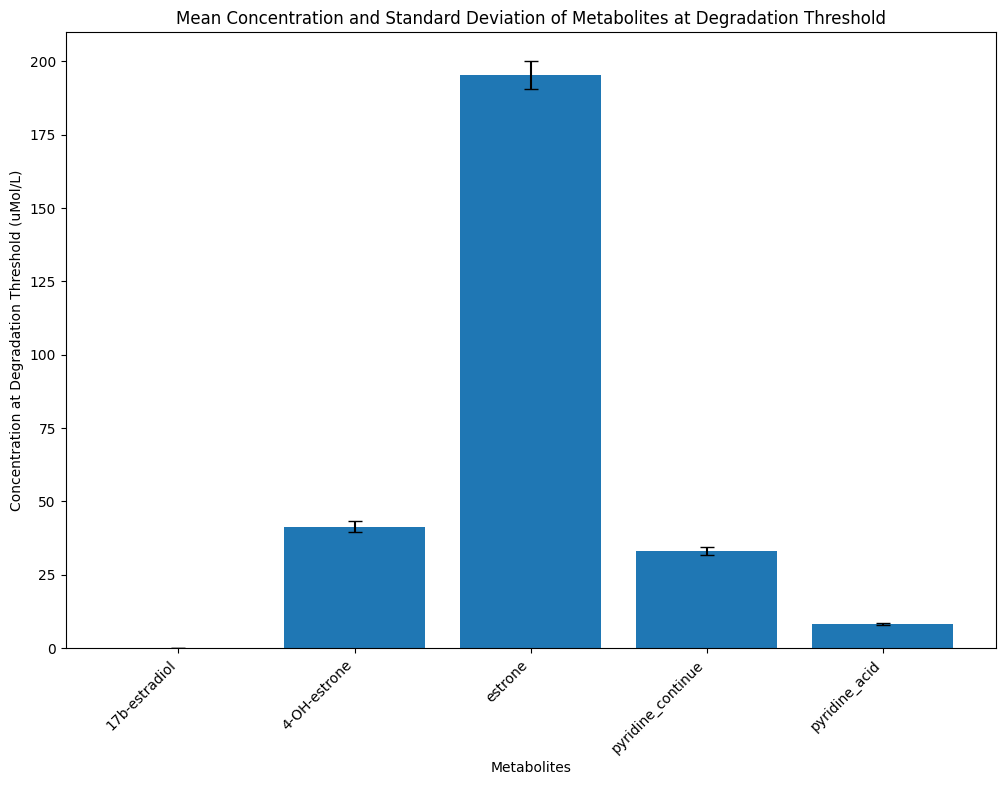

In [ ]:
# Compute mean and standard deviation for metabolite concentrations
mean_concentrations = np.mean(concentrations_at_deg, axis=0)
std_concentrations = np.std(concentrations_at_deg, axis=0)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.bar(metabolite_names, mean_concentrations, yerr=std_concentrations, capsize=5)
plt.xlabel('Metabolites')
plt.ylabel('Concentration at Degradation Threshold (uMol/L)')
plt.title('Mean Concentration and Standard Deviation of Metabolites at Degradation Threshold')
plt.xticks(rotation=45, ha='right')
plt.show()

Degradation Time Statistics:
Mean: 39.84
Standard Deviation: 0.01
Median: 39.84
1st Quartile: 39.84
3rd Quartile: 39.84


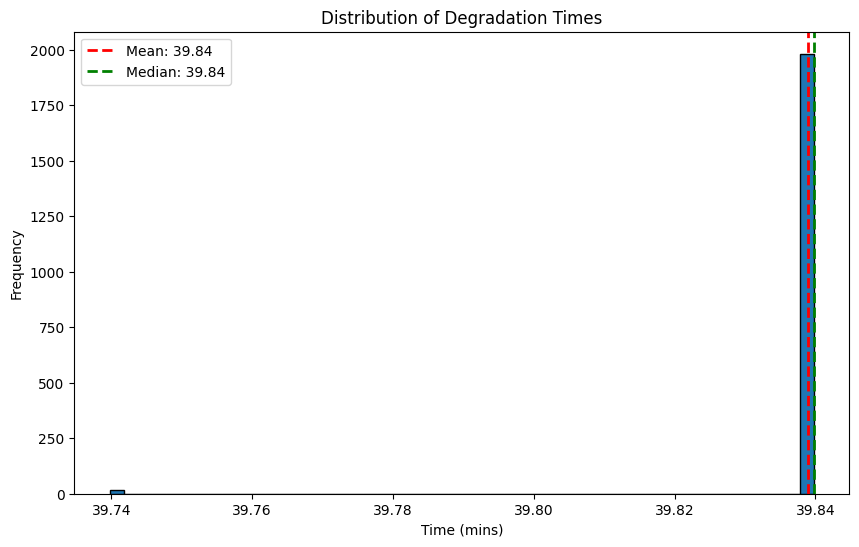

In [ ]:
# Analyze results
mean_time = np.mean(degradation_times)
std_time = np.std(degradation_times)
median_time = np.median(degradation_times)
q1_time = np.percentile(degradation_times, 25)
q3_time = np.percentile(degradation_times, 75)

print("Degradation Time Statistics:")
print(f"Mean: {mean_time:.2f}")
print(f"Standard Deviation: {std_time:.2f}")
print(f"Median: {median_time:.2f}")
print(f"1st Quartile: {q1_time:.2f}")
print(f"3rd Quartile: {q3_time:.2f}")

# Plot histogram of degradation times
plt.figure(figsize=(10, 6))
plt.hist(degradation_times, bins=50, edgecolor='black')
plt.title('Distribution of Degradation Times')
plt.xlabel('Time (mins)')
plt.ylabel('Frequency')
plt.axvline(mean_time, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f}')
plt.axvline(median_time, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f}')
plt.legend()
plt.show()

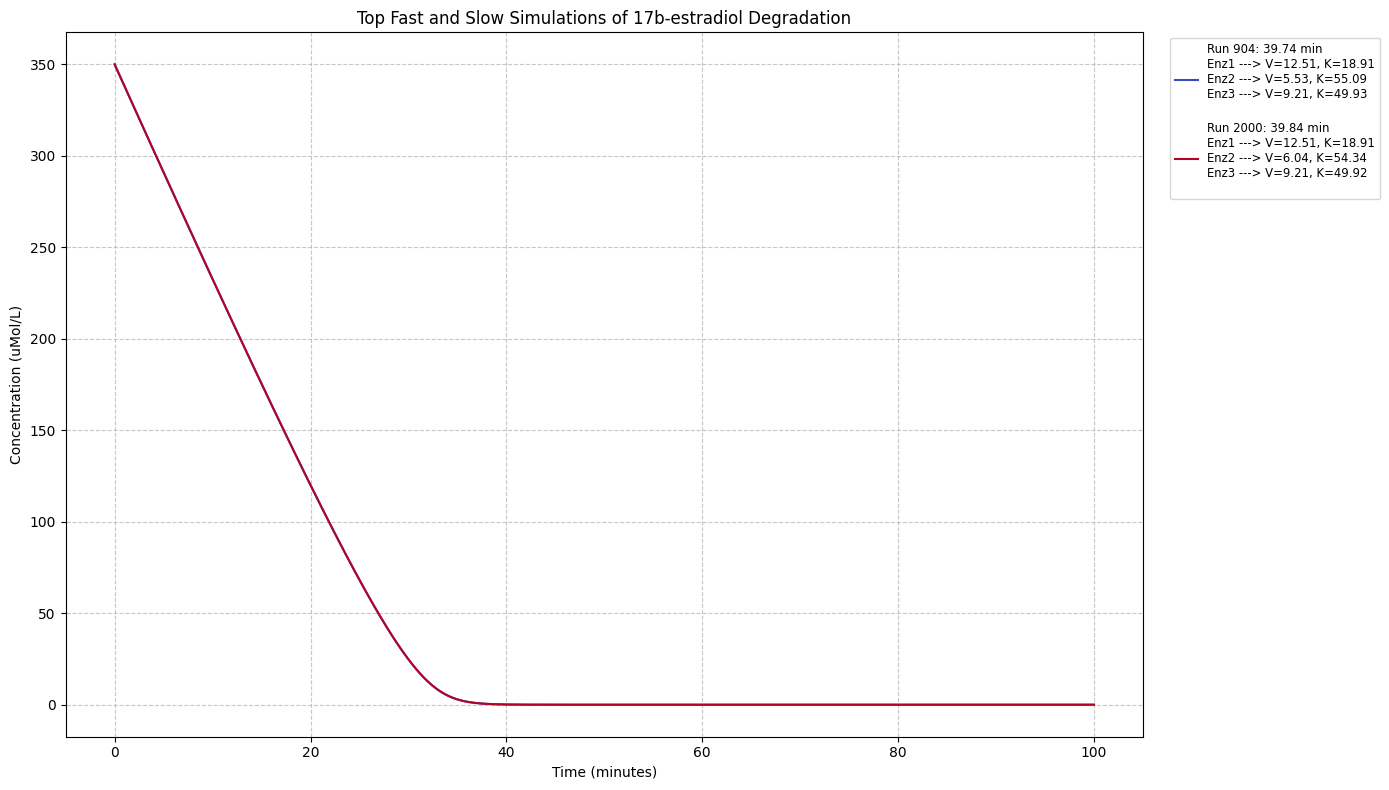


Degradation times and kinetic parameters for selected simulations:

Run 904:
Degradation time: 39.74 minutes
Kinetic parameters:
  Step 1 (Enz1): Vmax = 12.51, Km = 18.91
  Step 2 (Enz2): Vmax = 5.53, Km = 55.09
  Step 3 (Enz3): Vmax = 9.21, Km = 49.93

Run 2000:
Degradation time: 39.84 minutes
Kinetic parameters:
  Step 1 (Enz1): Vmax = 12.51, Km = 18.91
  Step 2 (Enz2): Vmax = 6.04, Km = 54.34
  Step 3 (Enz3): Vmax = 9.21, Km = 49.92


In [ ]:
def plot_top_simulations(degradation_times, solution_list, n_top=5, pathway=None, show_params_on_legend=False):
    # Select top fastest and slowest simulations
    sorted_indices = np.argsort(degradation_times)
    top_fast_indices = sorted_indices[:n_top]
    top_slow_indices = sorted_indices[-n_top:]
    top_indices = np.concatenate((top_fast_indices, top_slow_indices))

    # Generate colors for each simulation
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(top_indices)))

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Plot each selected simulation
    for i, (index, color) in enumerate(zip(top_indices, colors)):
        solution = solution_list[index]
        t = np.linspace(0, 100, len(solution))

        # Prepare the label for the legend
        label = f'Run {index+1}: {degradation_times[index]:.2f} min'

        # If you want, add parameter information to the legend
        if show_params_on_legend:
            np.random.seed(index)
            params = [(np.random.uniform(*step['Vmax_range']), np.random.uniform(*step['Km_range']))
                      for step in pathway]

            label += '\n'
            for j, ((Vmax, Km), step) in enumerate(zip(params, pathway)):
                label += f"{step['enzyme'][:10]} ---> V={Vmax:.2f}, K={Km:.2f}\n"

        # Plot the concentration over time for this simulation
        plt.plot(t, solution[:, 0], color=color, label=label)

    # Set plot labels and title
    plt.title('Top Fast and Slow Simulations of 17b-estradiol Degradation')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Concentration (uMol/L)')

    # Add legend and grid
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print detailed information about each selected simulation
    print("\nDegradation times and kinetic parameters for selected simulations:")
    for i, index in enumerate(top_indices):
        print(f"\n\033[1mRun {index+1}:\033[0m")
        print(f"\033[1mDegradation time: {degradation_times[index]:.2f} minutes\033[0m")
        np.random.seed(index)
        params = [(np.random.uniform(*step['Vmax_range']), np.random.uniform(*step['Km_range']))
                  for step in pathway]

        print("Kinetic parameters:")
        for j, ((Vmax, Km), step) in enumerate(zip(params, pathway)):
            print(f"  Step {j+1} ({step['enzyme']}): Vmax = {Vmax:.2f}, Km = {Km:.2f}")


# Call the function with your existing results and pathway information
plot_top_simulations(degradation_times, solution_list, n_top=1, pathway=pathway, show_params_on_legend=True)
# n_top means the number of top degradation times (either slow or fast). Example: n_top=2 means show the 2 fastest & 2 slowest degradations times.
# show_params_on_legend should be True if you want to display the kinetic parameter values in the legend